# Analysis of transaction lifecycle

<strong><font color="red">DRAFT: NEEDS QA REVIEW</font></strong>

*How long does it take, after a transaction is reaches the memory pool, for it to be reference by an RB?*

![Diagram of Leios pipeline stages](../tx-to-block-fig1.png)

![Description of Leios pipeline stages](../tx-to-block-fig2.png)

## Setup

### Import modules

In [2]:
--
-- ∆Q using Rationals
--
import DeltaQ

-- needed for visualisation within iHaskell
import Graphics.Rendering.Chart.Renderable

-- Other modules
import Data.Ratio (approxRational)

-- useful for rendering Rationals with 'just enough' precision
asFloat :: Rational -> Float
asFloat = fromRational

### Negative binomial distribution

We're only interested in the time to the first success, the random variable $\mathbf{S}$, so we have the following probability density and cumulative distribution, given a probability of $f$ for the event occuring in a time step.

$$
b(s, f) := \mathcal{P}[\mathbf{S} = s ] = \left( 1 - f \right) ^s \cdot f
$$

$$
B(s, f) := \mathcal{P}[\mathbf{S} \leq s] = \sum_{0 \leq t \leq s} \left( 1 - f \right) ^t \cdot f
$$


In [ ]:
dnbinom :: Rational
        -> Int
        -> [(

### Converting rate to probability

If $f$ is the rate of events per-trial (i.e., per-slot or per-stage), then $(1 - e^{-f})$ is the probability that at least on event will be observed in a given trial.

## Slot progression

In [63]:
slotLength :: Rational
slotLength = 1

In [64]:
slot :: Int -> DQ
slot n = if n > 1 then wait slotLength else never

## Wait for next stage

In [62]:
stageLength :: Int
stageLength = 10

In [67]:
[ 0.4^i * 0.6^(stageLength - i) | i <- [1..stageLength]]

[4.0310784e-3,2.6873856000000002e-3,1.7915904000000002e-3,1.1943936000000004e-3,7.962624000000004e-4,5.308416000000003e-4,3.5389440000000024e-4,2.359296000000002e-4,1.5728640000000013e-4,1.0485760000000011e-4]

In [69]:
stage :: DQ
stage = wait $ fromIntegral stageLength

In [86]:
-- negative binomial

In [83]:
nextStage :: Rational -> DQ
nextStage p =
  choices $ zipWith (\i x -> (x / psum, wait i)) [1..] ps
  where
    q = 1 - p
    ps = [p^n * q^(stageLength - n) | n <- [1..stageLength]]
    psum = sum ps

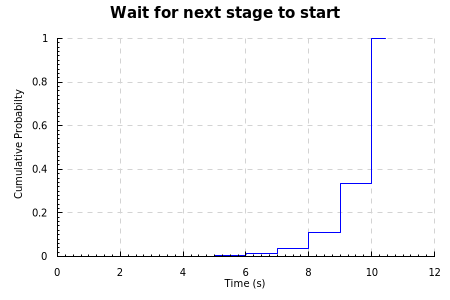

In [85]:
toRenderable $ plotCDF "Wait for next stage to start" $ nextStage 0.75

## Transaction diffusion

In [54]:
tx :: DQ
tx = uniform 0 1 .>>. choices
       [
         (0.25, wait 1)
       , (0.50, wait 2)
       , (0.25, wait 3)
       ]

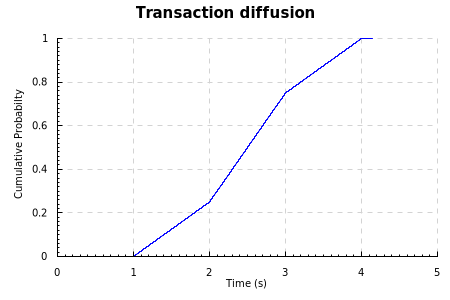

In [55]:
toRenderable $ plotCDF "Transaction diffusion" tx

## Transaction included in IB

In [56]:
k :: Int
k = 3

In [57]:
f = 1.0

In [58]:
p = 1 - exp(- f / fromIntegral k) `approxRational` 1e-6

In [59]:
txInIb n = slot n .>>. choice p (wait 0) (txInIb $ n - 1)

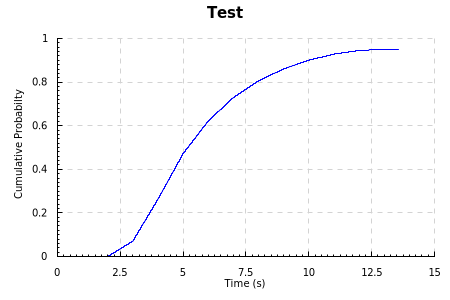

In [60]:
toRenderable $ plotCDF "Test" $ tx .>>. txInIb 10